## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project seeks to analyze the impact of an A/B test run by an e-commerce website. It calculates probability and runs A/B Tests and logistic regressions to help the company understand if they should implement the new page, keep the old page, or run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

In [57]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
random.seed(42)

Let's take a look at the company's dataset:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


##### Initial observations about the dataset:

In [3]:
df.shape[0]
# There are 294,478 records in this dataset.

294478

In [4]:
df['user_id'].nunique()
# There are 290,584 unique users:

290584

In [5]:
df['converted'].mean()
# 11.97% of the records reflect users that converted to customers.

0.11965919355605512

##### Data cleaning

In [6]:
# First we should look for any records with conflicting information, 
#   where users were identified as being in one test group but appeared
#   to view the page intended for the other group.
print(df.query('group == "control" & landing_page == "new_page"').count())
print(df.query('group == "treatment" & landing_page == "old_page"').count())

user_id         1928
timestamp       1928
group           1928
landing_page    1928
converted       1928
dtype: int64
user_id         1965
timestamp       1965
group           1965
landing_page    1965
converted       1965
dtype: int64


In [7]:
# We should also check for missing values.
df.info()
# There are no missing values:
#   All of the columns have the same number of rows with data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# We should create a new dataframe only using the records where the data
#   clearly indicate the user's test group.
df2 = df.query('group == "treatment" & landing_page == "new_page"')

In [9]:
df2a = df.query('group == "control" & landing_page == "old_page"')

In [10]:
df2 = df2.append(df2a)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 2 to 294476
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [11]:
# We can confirm that the conlficting rows were removed:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
# We shoud check whether there are duplicates in this revised dataset:
df2['user_id'].nunique()

290584

In [13]:
#There is one user with a duplicate record. 
#  We should remove one of these records.
df2["duplicated"] = df2['user_id'].duplicated()

In [14]:
df2.query('duplicated')

,user_id,timestamp,group,landing_page,converted,duplicated
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


In [15]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0,True


In [16]:
df3 = df2.drop_duplicates('user_id')

In [17]:
df3.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted,duplicated
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0,False


In [18]:
df3['user_id'].nunique()

290584

##### Assessing the probability of conversion
a. What is the probability of an individual converting regardless of the page they receive?

In [19]:
df3['converted'].mean()
# The probability of converting regardless of the page viewed was 11.96%.

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control = df3.query('group == "control"')
control['converted'].mean()
# The probability of converting if an individual was in the control group
#   was 12.04%.

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treatment = df3.query('group == "treatment"')
treatment['converted'].mean()
# The probability of converting if an individual was in the treatment group
#   was 11.88%.

0.11880806551510564

d. What is the probability that an individual received the new page?

In [22]:
# About half of the users received a new page:
df3[['new_page','old_page']] = pd.get_dummies(df['landing_page'])
df3.head()

,user_id,timestamp,group,landing_page,converted,duplicated,new_page,old_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,False,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,False,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,False,1,0


In [23]:
df3['new_page'].mean()

0.5000619442226688

##### Preliminary conclusions

At this point there is not sufficient evidence to conclude that the treatment page leads to more conversions. In fact, the probability of converson is slightly higher on the control page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, we will evaluate the page based on the data given. If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, you would state the null and alternative hypotheses as such:

$$H_0: p_{old} \geq p_{new} $$
$$H_1: p_{old} < p_{new} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in the dataset regardless of the page. <br><br>

#### Simulating the null hypothesis

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [24]:
p_new = df3['converted'].mean()

In [25]:
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [26]:
p_old = df3['converted'].mean()

c. What is $n_{new}$, the number of individuals in the treatment group?

In [27]:
treatment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145310 entries, 2 to 294477
Data columns (total 6 columns):
user_id         145310 non-null int64
timestamp       145310 non-null object
group           145310 non-null object
landing_page    145310 non-null object
converted       145310 non-null int64
duplicated      145310 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 6.8+ MB


In [28]:
n_new = int(145310)

d. What is $n_{old}$, the number of individuals in the control group?

In [29]:
control.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145274 entries, 0 to 294476
Data columns (total 6 columns):
user_id         145274 non-null int64
timestamp       145274 non-null object
group           145274 non-null object
landing_page    145274 non-null object
converted       145274 non-null int64
duplicated      145274 non-null bool
dtypes: bool(1), int64(2), object(3)
memory usage: 6.8+ MB


In [30]:
n_old = int(145274)

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
new_page_converted.mean()

0.11851214644553025

In [34]:
old_page_converted.mean()

0.12157027410273001

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [35]:
new_means, old_means, p_diffs = [], [], []

for _ in range(10000):
    new_mean = np.random.binomial(1, p_new, n_new).mean()
    old_mean = np.random.binomial(1, p_old, n_old).mean()
    new_means.append(new_mean)
    old_means.append(old_mean)
    p_diffs.append(new_mean-old_mean)

#### Histogram of the sampling distribution:

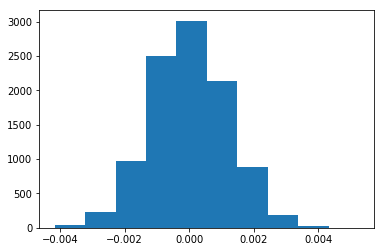

In [36]:
plt.hist(p_diffs);

The plot is normall distributed, as expected. The Central Limit Theorm states that with large sample sizes, the sampling distribution of the mean will be normally distributed.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
actual = abs(treatment['converted'].mean() - control['converted'].mean())

In [38]:
p_diffs = np.array(p_diffs)

In [39]:
simulated = abs(p_diffs)

In [40]:
diff = simulated - actual

In [41]:
diff = np.array(diff)

In [42]:
greater = (diff>0).sum()

In [43]:
less_eq = (diff<=0).sum()

In [44]:
diff.shape[0]

10000

In [45]:
greater/(diff.shape[0])
# 19% of p_diffs are greater than the actual difference observed in the dataset.

0.1833

The value calculated in part j is called the p-value. The p-value is the probability of obtaining the observed statistic or one more extreme if the null hypothesis is true. An 19% chance of observing this statistic in higher than confidence intervals tend to be; therefore, we fail to reject the null hypothesis. This suggests there is little chance of the new page making a significant difference in the conversion rate.

l. We can also use a built-in to achieve similar results. Below we will use a built-in model, stats.proportions_ztest, to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [48]:
convert_old = df3.query('landing_page == "old_page" & converted==True')['user_id'].count()
convert_new = df3.query('landing_page == "new_page" & converted==True')['user_id'].count()
n_old = df3.query('landing_page == "old_page"')['user_id'].count()
n_new = df3.query('landing_page == "new_page"')['user_id'].count()

m. We will now use `stats.proportions_ztest` to compute your test statistic and p-value. 

In [49]:
z_score1, p_value1 = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new], alternative='larger')
z_score1, p_value1

(1.3109241984234394, 0.09494168724097551)

In [50]:
from scipy.stats import norm
norm.cdf(z_score1)

0.9050583127590245

The z-score is not statistically significant as it is between -1.96 and +1.96. The p-value of 0.09 is not significant. In alignment with the A/B test, we again fail to reject the null hypothesis and cannot claim that the new page converts more viewers than the old page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will assess the effectiveness of the new page in contrast with the old page using regression analyses.

As we are trying to predict a binary outcome, a logistic regression would be appropriate.

b. The goal is to use **statsmodels** to fit the logistic regression model to see if there is a significant difference in conversion based on which page a customer receives. 

#### Model 1: Single-variable logistic regression
To start, we first need to create a column for the intercept, and a dummy variable column for which page each user received:

In [51]:
df3['intercept'] = 1

df3[['control','ab_page']] = pd.get_dummies(df3['group'])

In [52]:
df3.drop('control',axis=1)
df3.head()

,user_id,timestamp,group,landing_page,converted,duplicated,new_page,old_page,intercept,control,ab_page
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,False,1,0,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,False,1,0,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,False,1,0,1,0,1


c. We will use **statsmodels** to instantiate the regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [53]:
logit_mod = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [54]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 02 May 2019   Pseudo R-squ.:               8.077e-06
Time:                        00:09:49   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [55]:
np.exp(result.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

This regression suggests that conversion is just about as likely (~1 times) to occur on the new page as on the old page. In other words, the new page does not appear to encourage more users to convert.

Note the p-value associated with ab_page is 0.19. This value is double the one-sided z-test. If we run a two-sided z-test, we get a p-value of 0.19 (see below). The two-sided test has a higher p-value and is more rigorous:

In [56]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new],[n_old,n_new])
z_score, p_value

(1.3109241984234394, 0.18988337448195103)

Let's also assess the accuracy of this model using train_test_split: 

In [58]:
y0 = df3['converted']
X0 = df3['ab_page']

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size=0.20, random_state=0)

In [60]:
X_train0= X_train0.values.reshape(-1, 1)
X_test0 = X_test0.values.reshape(-1, 1)

In [61]:
log_mod0 = LogisticRegression()
log_mod0.fit(X_train0, y_train0)
preds0 = log_mod0.predict(X_test0)
confusion_matrix(y_test0, preds0)

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [62]:
recall_score(y_test0, preds0)

0.0

In [63]:
precision_score(y_test0, preds0)

0.0

In [64]:
accuracy_score(y_test0, preds0)
# The accuracy rate, or 
#  the amount of correct classifications made by the model,
#  is 0.88

0.8799490682588571

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The time frame of the study is important to consider.

In [65]:
print(control['timestamp'].min(),control['timestamp'].max())
print(treatment['timestamp'].min(),treatment['timestamp'].max())
# It appears that the control and treatment were run at the same time. 
#   Adding in this information may not improve the model.

2017-01-02 13:42:15.234051 2017-01-24 13:41:54.460509
2017-01-02 13:42:05.378582 2017-01-24 13:41:44.097174


It looks like users in both groups accessed the site within the same time frame.

We want to be careful about adding more variables to a logistic regression as it makes the results more difficult to interpret. Therefore, we should only include the additional variables if they improve the model. Let's see if adding the users' country improves the model.

### Model 2: Conversion by Country

g. Perhaps the location of the users impacted their choice to convert or not. 
Does it appear that country had an impact on conversion? 

In [66]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [67]:
df4 = df3.join(countries,  on='user_id', lsuffix='_df3', rsuffix='_c')
# Not sure why this join didn't work/used the merge below.

In [68]:
df5 = pd.merge(df3, countries, how='left', on='user_id')

In [69]:
df5.groupby('country').count()

,user_id,timestamp,group,landing_page,converted,duplicated,new_page,old_page,intercept,control,ab_page
country,,,,,,,,,,,
CA,14499,14499,14499,14499,14499,14499,14499,14499,14499,14499,14499
UK,72466,72466,72466,72466,72466,72466,72466,72466,72466,72466,72466
US,203619,203619,203619,203619,203619,203619,203619,203619,203619,203619,203619


In [70]:
df5[['CA','UK','US']] = pd.get_dummies(df5['country'])

In [71]:
countries_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','UK','US']])
countries_result = countries_mod.fit()
countries_result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 May 2019   Pseudo R-squ.:               2.323e-05
Time:                        00:12:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [72]:
np.exp(countries_result.params)

intercept    0.131332
ab_page      0.985168
UK           1.051944
US           1.041599
dtype: float64

Holding the country of the users constant, this model shows that conversion is still about equally as likely to occur on the new page as on the old page. The z-score and p-values for the treatment page also remained the same. The accuracy is also the same, below:

In [73]:
y = df5['converted']
X = df5[['ab_page','UK','US']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [74]:
log_mod = LogisticRegression()
log_mod.fit(X_train, y_train)
preds = log_mod.predict(X_test)
confusion_matrix(y_test, preds)

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [75]:
accuracy_score(y_test, preds)

0.8799490682588571

### Model 3: Interaction between country and page
h. We would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [76]:
df5['page_UK'] = df5['ab_page']*df5['UK']
df5['page_US'] = df5['ab_page']*df5['US']
df5['page_CA'] = df5['ab_page']*df5['CA']

In [77]:
interaction_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','UK','US','page_UK']])
interaction_result = interaction_mod.fit()
interaction_result.summary()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 02 May 2019   Pseudo R-squ.:               3.125e-05
Time:                        00:12:51   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1557
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0257      0.027    -75.518      0.000      -2.078      -1.973
ab_page       -0.0236      0.013     -1.785      0.074      -0.049       0.002
UK             0.0335      0.031      1.070      0.285      -0.028       0.095
US             0.0407      0.027      1.515      0.130      -0.012       0.093
page_UK        0.0344      0.026      1.306      0.192      -0.017       0.086
==============================================================================
"""

In [78]:
np.exp(interaction_result.params)

intercept    0.131901
ab_page      0.976686
UK           1.034052
US           1.041571
page_UK      1.035024
dtype: float64

In [79]:
interaction_mod2 = sm.Logit(df5['converted'],df5[['intercept','ab_page','UK','US','page_US']])
interaction_result2 = interaction_mod2.fit()
interaction_result2.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 02 May 2019   Pseudo R-squ.:               2.589e-05
Time:                        00:12:58   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0366      0.028    -72.618      0.000      -2.092      -1.982
ab_page       -0.0018      0.021     -0.086      0.931      -0.043       0.039
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0501      0.030      1.691      0.091      -0.008       0.108
page_US       -0.0188      0.025     -0.752      0.452      -0.068       0.030
==============================================================================
"""

In [80]:
np.exp(interaction_result2.params)

intercept    0.130468
ab_page      0.998202
UK           1.052017
US           1.051427
page_US      0.981411
dtype: float64

In [81]:
y2 = df5['converted']
X2 = df5[['ab_page','UK','US','page_UK']]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.20, random_state=0)

log_mod2 = LogisticRegression()
log_mod2.fit(X_train2, y_train2)
preds2 = log_mod2.predict(X_test2)
confusion_matrix(y_test2, preds2)

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [82]:
accuracy_score(y_test2, preds2)

0.8799490682588571

Adding the UK/page interaction slightly improved the p-value, although it was not statistically significant. Adding the US/page interaction greatly increased the p-value. None of the models tested were significant. All had an accuracy level around 87%.

Therefore, I would leave out the country variables as they did not improve the model.

### Model 4: Conversion by Week

Let's now consider the time the users accessed the page to see if that influenced their choices. First, let's break down the results by week:

In [83]:
df5['timestamp'] = pd.to_datetime(df5['timestamp'])

In [84]:
df5['week'] = df5['timestamp'].dt.week

In [85]:
df5.groupby('week').count()

,user_id,timestamp,group,landing_page,converted,duplicated,new_page,old_page,intercept,control,ab_page,country,CA,UK,US,page_UK,page_US,page_CA
week,,,,,,,,,,,,,,,,,,
1,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924,84924
2,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583,92583
3,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293,92293
4,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784,20784


In [86]:
df5[['w1','w2','w3','w4']] = pd.get_dummies(df5['week'])

In [87]:
wk_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','w2','w3','w4']])
wk_result = wk_mod.fit()
wk_result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 02 May 2019   Pseudo R-squ.:               2.479e-05
Time:                        00:13:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2603
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9979      0.012   -165.863      0.000      -2.022      -1.974
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
w2             0.0018      0.015      0.121      0.904      -0.027       0.031
w3             0.0195      0.015      1.331      0.183      -0.009       0.048
w4             0.0328      0.024      1.383      0.167      -0.014       0.079
==============================================================================
"""

In [88]:
df5['page_w2'] = df5['ab_page']*df5['w2']

In [89]:
df5['page_w3'] = df5['ab_page']*df5['w3']

In [90]:
df5['page_w4'] = df5['ab_page']*df5['w4']

In [91]:
wk_interact_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','w4','page_w4']])
wk_interact_result = wk_interact_mod.fit()
wk_interact_result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 May 2019   Pseudo R-squ.:               1.434e-05
Time:                        00:13:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3839
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9906      0.008   -237.668      0.000      -2.007      -1.974
ab_page       -0.0149      0.012     -1.258      0.208      -0.038       0.008
w4             0.0256      0.031      0.828      0.408      -0.035       0.086
page_w4       -0.0003      0.044     -0.006      0.995      -0.087       0.086
==============================================================================
"""

In [92]:
np.exp(wk_interact_result.params)

intercept    0.136608
ab_page      0.985170
w4           1.025929
page_w4      0.999724
dtype: float64

In [93]:
y3 = df5['converted']
X3 = df5[['ab_page','w2','w3','w4']]

X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.20, random_state=0)

log_mod3 = LogisticRegression()
log_mod3.fit(X_train3, y_train3)
preds3 = log_mod3.predict(X_test3)
confusion_matrix(y_test3, preds3)

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [94]:
accuracy_score(y_test3, preds3)

0.8799490682588571

It looks like the impact of the new page remains insignificant even after factoring in the week the page was viewed. The level of accuracy of the model also remains the same.

### Model 5: Conversion by Weekday

Finally, let's see if whether viewing the page on a weekday or weekend had an impact on the results:

In [95]:
df5['timestamp'] = pd.to_datetime(df5['timestamp'])

df5['weekday'] = df5['timestamp'].dt.dayofweek

In [96]:
# Map weekdays to 1 and weekends to 0
df5['weekday'] = df5['weekday'].map({0:1,1:1,2:1,3:1,4:1,5:0,6:0})
# Source: https://stackoverflow.com/questions/23307301/replacing-column-values-in-a-pandas-dataframe

In [97]:
wkday_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','weekday']])
wkday_result = wkday_mod.fit()
wkday_result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 02 May 2019   Pseudo R-squ.:               8.088e-06
Time:                        00:13:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.4230
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9883      0.012   -161.575      0.000      -2.012      -1.964
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
weekday       -0.0006      0.013     -0.049      0.961      -0.026       0.024
==============================================================================
"""

In [98]:
df5['page_wkday'] = df5['ab_page']*df5['weekday']

In [99]:
pg_wkday_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','weekday','page_wkday']])
pg_wkday_result = pg_wkday_mod.fit()
pg_wkday_result.summary()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 02 May 2019   Pseudo R-squ.:               2.071e-05
Time:                        00:13:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2209
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9733      0.015   -129.017      0.000      -2.003      -1.943
ab_page       -0.0455      0.022     -2.082      0.037      -0.088      -0.003
weekday       -0.0214      0.018     -1.189      0.234      -0.057       0.014
page_wkday     0.0420      0.026      1.638      0.101      -0.008       0.092
==============================================================================
"""

In [100]:
np.exp(pg_wkday_result.params)

intercept     0.138999
ab_page       0.955529
weekday       0.978826
page_wkday    1.042905
dtype: float64

In [101]:
y4 = df5['converted']
X4 = df5[['ab_page','weekday','page_wkday']]

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.20, random_state=0)

log_mod4 = LogisticRegression()
log_mod4.fit(X_train4, y_train4)
preds4 = log_mod4.predict(X_test4)
confusion_matrix(y_test4, preds4)

array([[51140,     0],
       [ 6977,     0]], dtype=int64)

In [102]:
accuracy_score(y_test4, preds4)

0.8799490682588571

The model with the interaction between weekday suggests a statistically significant difference between the new and old pages (p-value=0.037). However, these results are not practically significant: Themagnitude of impact of the new page is negligeable as the exponent of the coefficient is slightly under 1, meaning the new page is slightly less effective.

### Model 6: Combining all the variables

To more thoroughly examine all of the variables, let's create a model with both country and weekday information, along with the page/weekday interaction, since that was statistically significant:

In [103]:
all_mod = sm.Logit(df5['converted'],df5[['intercept','ab_page','UK','US','weekday','page_wkday']])
all_result = all_mod.fit()
all_result.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 02 May 2019   Pseudo R-squ.:               3.586e-05
Time:                        00:13:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1779
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0146      0.030    -67.977      0.000      -2.073      -1.956
ab_page       -0.0454      0.022     -2.080      0.038      -0.088      -0.003
UK             0.0506      0.028      1.783      0.075      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
weekday       -0.0213      0.018     -1.186      0.236      -0.057       0.014
page_wkday     0.0420      0.026      1.638      0.101      -0.008       0.092
==============================================================================
"""

In [104]:
np.exp(all_result.params)

intercept     0.133377
ab_page       0.955576
UK            1.051937
US            1.041599
weekday       0.978877
page_wkday    1.042900
dtype: float64

This model showed comparable results to model 5. Adding the country information back in to the model did not improve the strength or accuracy.

## Conclusion

The A/B tests and the logistic regressions all suggest that the new page would not be an improvement. Although looking at the interaction between whether the user viewed the new page or the old page on a weekday or weekend was statistically significant, it was not practically significant. The new page is slightly less effective but perhaps not different enough from the old page to learn from what customers like.

### Recommendations

Before forgoing website redesign completely, further research may be needed. Notabley, the study only took place during the period of less than one month. Two phenomena that can influence the results are the novelty effect and change aversion. Individuals in the treatment group, if they are familiar with and used to the old site, may either be more inclined to like the new page due to its newness, or less inclined due to change aversion, regardless of the merits of the page itself. One way to safeguard against these phenomena is to run the study over a wide period of time to allow for the novelty to wear off. 

In [105]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0